## Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [3]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 3
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [4]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [5]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [6]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Initializing other processors...
Done.
Creating an alignment for 1084/1086 [99%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 480/1086 spectra (44%)


## 3. Load in the fall off results

In [7]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

480

## 4. Run all analysis
### Plot the raw results

In [8]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 5 artists>

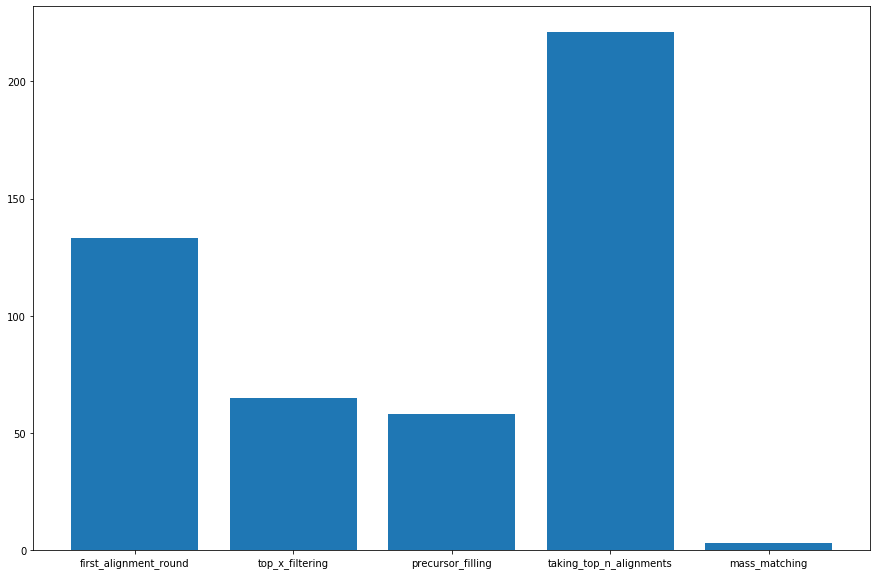

In [9]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### Just hybrid results

In [10]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

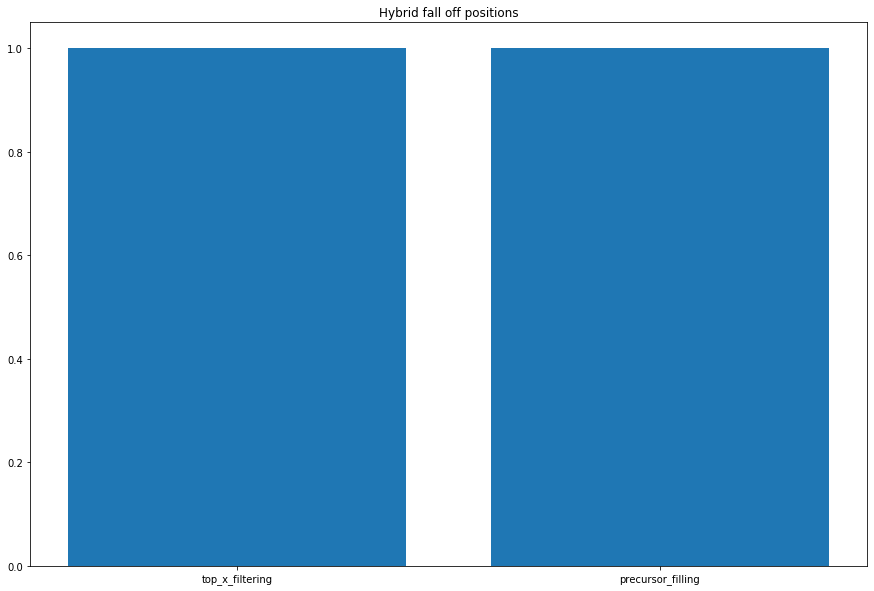

In [11]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

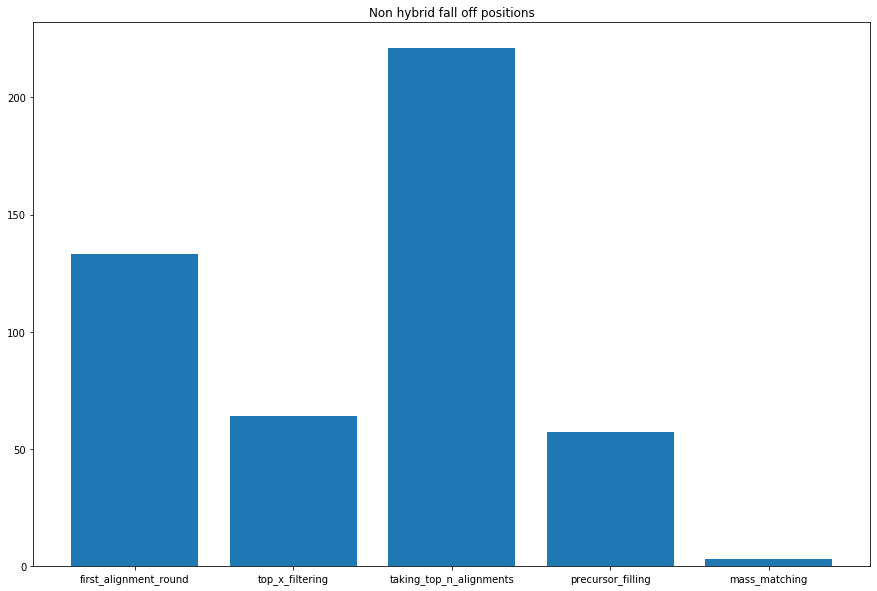

In [12]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [13]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [14]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLINPVE', 'DLQTL-INPVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLPNVE', 'DLQTL-PNVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLGAPVE', 'DLQTL-GAPVE']
After



In [15]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [16]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DLQ
DIQ
DLQL
DLQI
DIQI
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
NAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
#### Precursor filling

In [17]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [18]:
# go through every entry and find the sequences that were closest to the real sequence as possible
# closeness is: 
#   1. Having a lot of the right amino acids
#   2. Not have too many amino acids or too few
# Prioritize 1, rank by 2
def closeness(t_seq, trying, observed_precursor) -> (int, int):
    
    from_right = 0
    from_left = 0
    
    prec_distance = abs(gen_spectra.get_precursor(trying) - observed_precursor)
    
    # first check if they ARE the same
    if t_seq == trying:
        return (len(t_seq), 0, prec_distance)
    
    # go from left to right
    i = 0
    while i < len(t_seq) and i < len(trying) and t_seq[i] == trying[i]:
        i += 1
        from_left += 1
        
    # now right to left
    i = -1
    while abs(i) < len(t_seq) + 1 and abs(i) < len(trying) + 1 and t_seq[i] == trying[i]:
        i -= 1
        from_right += 1
        
    return (from_left + from_right, abs(len(t_seq) - len(trying)), prec_distance)

for _id, nhpfo in nh_precursor_fall_off:
    
    # get the real sequence
    t_seq = nhpfo['truth_sequence']
    
    # keep track of the best of the close ones 
    overlapped_idxed_close_hits = defaultdict(list)
    
    observed_prec = nhpfo['meta_data']['observed_precursor_mass']
    
    for non_hyb, hyb in nhpfo['meta_data']['sequences_before_precursor_filling']:
        overlap, dist, prec_dist = closeness(t_seq, non_hyb, observed_prec)
        overlapped_idxed_close_hits[overlap].append((non_hyb, hyb, dist, prec_dist))
        
    # now get the hightest key
    best_key = max(list(overlapped_idxed_close_hits.keys()))
    
    # show the best results sorted by their distance
    print(f'Hits with the most overlap ({best_key} AAs) for sequence {t_seq}')
    print('=====================================================================================')
    for seq, hyb_seq, dist, prec_distance in sorted(overlapped_idxed_close_hits[best_key], key=lambda x: x[2]):
        print(f'{seq} \t {dist} \t {prec_distance} \t {hyb_seq}')
        
    print()
    

Hits with the most overlap (18 AAs) for sequence DTGAGSIREAGGAFGKREKAEE
GSIREAGGAFGKREKAEE 	 4 	 1443.9353470999997 	 None

Hits with the most overlap (39 AAs) for sequence DGPVQGTIHFEQKASGEPVVLSGQITGLTEGQHGFHVHQYG
PVQGTIHFEQKASGEPVVLSGQITGLTEGQHGFHVHQYG 	 2 	 3445.5503740999998 	 None

Hits with the most overlap (16 AAs) for sequence VEYPAHQAMNLVGPQSIEGGAHEGLQHLGPFGNIPNIVA
VEYPAHQAMNLPNIVA 	 23 	 750.6255800999995 	 VEYPAHQAMNL-PNIVA

Hits with the most overlap (6 AAs) for sequence DLTIKLP
KLTIKLP 	 0 	 412.3108601000001 	 KL(T)IKLP
KLLTIKLP 	 1 	 525.3949241 	 KLL(T)IKLP
KILTIKLP 	 1 	 525.3949241 	 KIL(T)IKLP
LTIKLP 	 1 	 284.2158971 	 None
KLKLTIKLP 	 2 	 653.4898870999998 	 KLKL-TIKLP
KKSLTIKLP 	 2 	 627.4378511 	 KKSL-TIKLP
IKTLTIKLP 	 2 	 626.4426030999998 	 IKTL-TIKLP
KKLLTIKLP 	 2 	 653.4898871 	 KKLL-TIKLP
KTLLTIKLP 	 2 	 626.4426030999998 	 KTLL-TIKLP
LKTLTIKLP 	 2 	 626.4426030999998 	 LKTL-TIKLP
KLTLTIKLP 	 2 	 626.4426030999998 	 KLTL-TIKLP
SLSLTIKLP 	 2 	 571.36401710000

Hits with the most overlap (14 AAs) for sequence DVMRALGQNPTNA
DVMRALGQNPTNTTAGKPEPNA 	 9 	 1819.2210461000004 	 DVMRALGQNPTN-TTAGKPEPNA
DVMRALGQNPTNTEGRYLFLNA 	 9 	 2017.3367351000002 	 DVMRALGQNPTN-TEGRYLFLNA
DVMRALGQNPTNSVTNSVHGNA 	 9 	 1819.1958921000005 	 DVMRALGQNPTN-SVTNSVHGNA
DVMRALGQNPTNAQAQAQAQVPA 	 10 	 1916.2850451 	 DVMRALGQNPTN-AQAQAQAQVPA
DVMRALGQNPTNLNKDHSTALNA 	 10 	 2017.3327201000006 	 DVMRALGQNPTN-LNKDHSTALNA
DVMRALGQNPTNPSVTNSVHGNA 	 10 	 1916.2486561000005 	 DVMRALGQNPTN-PSVTNSVHGNA
DVMRALGQNPTNATTQPQGTTQPPA 	 12 	 2131.3644191000003 	 DVMRALGQNPTN-ATTQPQGTTQPPA

Hits with the most overlap (14 AAs) for sequence EKIVVLLQRLKPEIK
KIVVLLQRLKPEIK 	 1 	 1315.0762260999998 	 None

Hits with the most overlap (20 AAs) for sequence DKATFMVGSYGPRPEEYEFLTPVEEAPKGMLARGTYHNKSFFT
DKATFMVGSYGPRPEEYEFLNHSAGMV 	 16 	 2215.1593281 	 DKATFMVGSYGPRPEEYEF-LNHSAGMV

Hits with the most overlap (20 AAs) for sequence DLIASSGEIIKVSAAGKEALPSWLHW
GEIIKVSAAGKEALPSWLHW 	 6 	 1496.8093591000004 

#### Taking the top n alignments

In [19]:
top_n = nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['taking_top_n_alignments']]

In [26]:
for _id, top_n_spec in top_n:
    t_seq = top_n_spec['truth_sequence']
    
    print(f'Top n alignments for sequence {t_seq}')
    print('============================================================')
    print('sequence \t b score \t y score \t total score \t precursor distance')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]}') for x in top_n_spec['meta_data']['top_n']]
    
    print('------------------------------------------------------------')
    print('Missed alignments for this sequence')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]}') for x in top_n_spec['meta_data']['not_top_n'][:10]]
    print('------------------------------------------------------------')
    all_alignments = [x for x in top_n_spec['meta_data']['top_n']] + [x for x in top_n_spec['meta_data']['not_top_n']]
    num_hyb = len([0 for x in all_alignments if 'hybrid_sequence' in x])
    p_hyb = int(100 * (float(num_hyb) / float(len(all_alignments))))
    scores = [x['total_score'] for x in all_alignments]
    avg_score = np.mean(scores)
    min_score = min(scores)
    
    print(f'Stats: \t Number alignments: {len(all_alignments)} \t % hybrid: {p_hyb} \t Average score: {avg_score} \t min score: {min_score}')
    print()

Top n alignments for sequence DSWGILFSHPR
sequence 	 b score 	 y score 	 total score 	 precursor distance
------------------------------------------------------------
IGIGICLFSHPR 	 4 	 5 	 9 	 0.6470210333333739
SSSQGILFSHPR 	 3 	 6 	 9 	 0.3382739666666339
SSSKGILFSHPR 	 3 	 6 	 9 	 0.3504022999999279
SSDPGILFSHPR 	 3 	 6 	 9 	 0.6653590333334023
SSPDGILFSHPR 	 3 	 6 	 9 	 0.6653590333334023
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
SSICGILFSHPR 	 3 	 6 	 9 	 0.6724882999999409
SSLCGILFSHPR 	 3 	 6 	 9 	 0.6724882999999409
SSPNGILFSHPR 	 3 	 6 	 9 	 0.9933643666666967
DSWGILFSHPR 	 1 	 7 	 8 	 0.0005187000000432818
SDQGVALFSHPR 	 3 	 6 	 7.5 	 0.3336090333333459
SDWGILFSHPR 	 2 	 7 	 7.5 	 0.0005187000000432818
SSSSNVLWLNGGP 	 4 	 3 	 7 	 0.9942839666666714
SSPSQALFSHPR 	 4 	 5 	 6.5 	 0.3336093666666784
SSVDGILFSHPR 	 3 	 6 	 6.5 	 0.006524299999966843
SSDVGILFSHPR 	 3

KKAAKMEKEYGSLK 	 2 	 3 	 5 	 0.47562292499998193
------------------------------------------------------------
Stats: 	 Number alignments: 1848 	 % hybrid: 93 	 Average score: 2.3333333333333335 	 min score: 0

Top n alignments for sequence WLIQTKITD
sequence 	 b score 	 y score 	 total score 	 precursor distance
------------------------------------------------------------
KGNIQTKITD 	 3 	 6 	 9 	 0.0021882499999037464
KNGIQTKITD 	 3 	 6 	 9 	 0.002188250000017433
KGNLQTKITD 	 3 	 6 	 8.0 	 0.0021882499999037464
KNGLQTKITD 	 3 	 6 	 8.0 	 0.002188250000017433
KNGIQTDKTI 	 3 	 5 	 8 	 0.002188250000017433
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
WLIQTKITD 	 2 	 6 	 8 	 0.00017674999992323137
KGNIQTDKTI 	 3 	 5 	 7.5 	 0.002188250000017433
KGNLQTDKTI 	 3 	 5 	 7.5 	 0.002188250000017433
KNGLQTDKTI 	 3 	 5 	 7.5 	 0.002188250000017433
KGNLQVCVRT 	 3 	 5 	 7.5 	 0.00545075000

Stats: 	 Number alignments: 3237 	 % hybrid: 93 	 Average score: 2.6337658325610134 	 min score: 1.5

Top n alignments for sequence DYRALVHER
sequence 	 b score 	 y score 	 total score 	 precursor distance
------------------------------------------------------------
SFDRLVHER 	 3 	 5 	 8 	 0.0006003666666742902
SHPPSLVHER 	 3 	 5 	 8 	 0.0006003666666742902
SFEVRVHER 	 3 	 5 	 8 	 0.0006003666666742902
SFRDLVHER 	 3 	 5 	 8 	 0.0006003666666742902
KFSQQVHER 	 3 	 6 	 7.5 	 0.0006000333333986418
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
SFEVRVEHR 	 3 	 4 	 7 	 0.0006003666666742902
DYRALVHER 	 2 	 5 	 7 	 0.0006030333333342242
VGFHVEALSSL 	 4 	 3 	 6.5 	 0.004039299999931245
GFVHVEALSSL 	 4 	 3 	 6.5 	 0.004039299999931245
KFSQQVEHR 	 3 	 5 	 6.5 	 0.0006000333333986418
SFQQKVHER 	 3 	 5 	 6.5 	 0.0006000333333986418
KGFQASVHER 	 3 	 5 	 6.5 	 0.0006000333333986418
SIPSHPV

QPQPPPQFYVSKQCTR 	 3 	 2 	 5 	 0.34002863333341793
------------------------------------------------------------
Stats: 	 Number alignments: 289 	 % hybrid: 95 	 Average score: 3.491349480968858 	 min score: 0

Top n alignments for sequence LISLMDTRLPHCTNEKIE
sequence 	 b score 	 y score 	 total score 	 precursor distance
------------------------------------------------------------
KPMEINPEMLKQEQELR 	 5 	 3 	 7.5 	 0.005987366666545313
KKMWGWLLVSLMSSRTCS 	 4 	 3 	 7 	 0.00682169999981852
ALFQDVQKIGIDPGYSKAY 	 3 	 4 	 7 	 0.00014396666665561497
ALFQDVQKLELGGGPGAGDLQ 	 3 	 4 	 7 	 0.0011907000001656343
ALFQDVQKLDIEAQIGGNPG 	 3 	 4 	 7 	 0.0011910333336118128
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
ALFQDVQKLETMIKTYGQ 	 3 	 4 	 7 	 0.0012709666666523844
ALFQDVQKFPHHLQEYI 	 3 	 4 	 7 	 0.0031517000001031192
ALFQDVQKITGLCVCKPYS 	 3 	 4 	 7 	 0.004648700000075223
ALFQDVQKLDEAAS